In [447]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier as KNN_sklearn
from sklearn.datasets import make_blobs, make_circles, make_moons, make_biclusters, make_checkerboard, make_classification
from scipy.spatial.distance import cdist
from datetime import datetime
from sortedcontainers import SortedList
from future.utils import iteritems
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error as mse


import warnings
warnings.filterwarnings('ignore')

### 1. KNN

#### 1.1 Проверка скорости выполнения программы

In [2]:
class KNN(object):
    def __init__(self, k):
        self.k = k
    
    def fit(self, X, y):
        self.X = np.array(X) # n*d
        self.y = np.array(y) # 1*n
        
    def predict(self, X):
        X = np.array(X) # m*d
        y = np.zeros(X.shape[0]) # 1*m
        dist_matrix = cdist(X, self.X, metric='euclidean') # m*n
        idx_k_min = np.argpartition(dist_matrix, self.k)[:,:self.k] # m*k
        
        for i, idx in enumerate(idx_k_min):
            counter = np.unique(self.y[idx], return_counts=True)
            if list(counter[1]).count(counter[1][0]) == len(list(counter[1])) and len(list(counter[1])) != 1 and False:
                Q = [np.sum(1/dist_matrix[i][idx][self.y[idx]==i]**2) for i in np.unique(self.y)]
                y[i] = np.argmax(Q)
            else:
                y[i] = counter[0][np.argmax(counter[1])]

        return y
        
    def score(self, y_predicted, y):
        return np.mean(y_predicted == y)

In [3]:
class KNN_test(object):
    def __init__(self, k):
        self.k = k
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X):
        y = np.zeros(len(X))
        
        # для каждого X[i]
            # вычислить расстояния от X[i] до self.X[j]
        
        for i, x in enumerate(X):
            sl = SortedList()
            for j, x_train in enumerate(self.X):
                diff = x - x_train
                d = diff.dot(diff)
                if ( len(sl) < self.k):
                    sl.add( (d, self.y[j]) )
                else:
                    if(d < sl[-1][0]):
                        del sl[-1]
                        sl.add( (d, self.y[j]) )
                        
            votes = {}
            
            for _, v in sl:
                votes[v] = votes.get(v, 0) + 1
            
            max_count = -1
            max_vote = 0
            for v, count in iteritems(votes):
                if (count > max_count):
                    max_count = count
                    max_vote = v
            y[i] = v
        return y
        
    def score(self, X_test, y_test):
        y_predicted = self.predict(X_test)
        return np.mean(y_predicted == y_test)

In [299]:
X, y = make_blobs(n_samples=100, centers=3, n_features=2, random_state=0)
K = np.arange(1,50,1)

0:00:25.290979


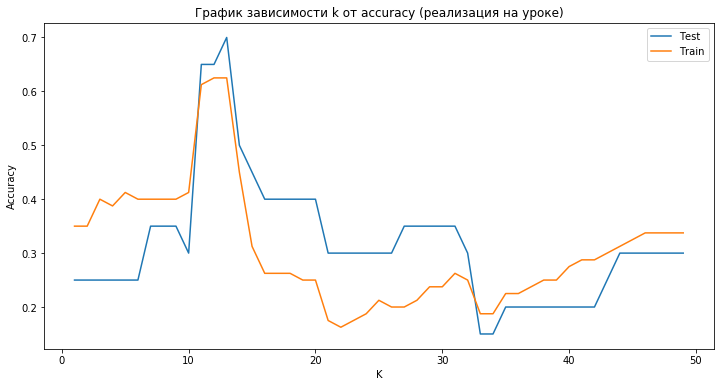

In [300]:
def get_knn_lesson(k, X_train, X_test, y_train, y_test):
    knn = KNN_test(k)
    knn.fit(X_train,y_train)
    return knn.score(knn.predict(X_test), y_test)

scores_test = []
scores_train = []
kf = KFold(n_splits = 5)


start_time = datetime.now()
for k in K:
    temp_score = []
    for train_indices, test_indices in kf.split(X):
        temp_score_test = []
        temp_score_train = []
        X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], y[train_indices], y[test_indices]
        temp_score_test.append(get_knn_lesson(k, X_train, X_test, y_train, y_test))
        temp_score_train.append(get_knn_lesson(k, X_train, X_train, y_train, y_train))
    scores_test.append(np.mean(temp_score_test))
    scores_train.append(np.mean(temp_score_train))
print(datetime.now() - start_time)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(K, scores_test, label='Test')
ax.plot(K, scores_train, label='Train')
ax.set(title = 'График зависимости k от accuracy (реализация на уроке)', xlabel = 'K', ylabel = 'Accuracy')
ax.legend()
plt.show()

0:00:00.905170


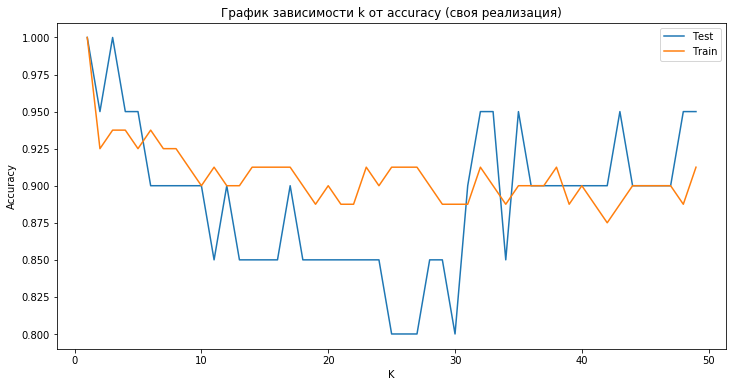

In [301]:
def get_knn_score(k, X_train, X_test, y_train, y_test):
    knn = KNN(k)
    knn.fit(X_train,y_train)
    return knn.score(knn.predict(X_test), y_test)

scores_test = []
scores_train = []
kf = KFold(n_splits = 5)


start_time = datetime.now()
for k in K:
    temp_score = []
    for train_indices, test_indices in kf.split(X):
        temp_score_test = []
        temp_score_train = []
        X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], y[train_indices], y[test_indices]
        temp_score_test.append(get_knn_score(k, X_train, X_test, y_train, y_test))
        temp_score_train.append(get_knn_score(k, X_train, X_train, y_train, y_train))
    scores_test.append(np.mean(temp_score_test))
    scores_train.append(np.mean(temp_score_train))
print(datetime.now() - start_time)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(K, scores_test, label='Test')
ax.plot(K, scores_train, label='Train')
ax.set(title = 'График зависимости k от accuracy (своя реализация)', xlabel = 'K', ylabel = 'Accuracy')
ax.legend()
plt.show()

0:00:00.986049


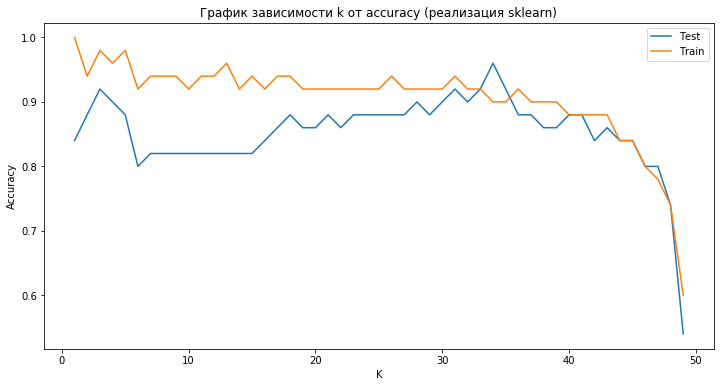

In [302]:
def get_knn_sklearn(k, X_train, X_test, y_train, y_test):
    knn = KNN_sklearn(k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    return knn.score(X_test, y_test)

scores_test = []
scores_train = []
kf = KFold(n_splits = 2)


start_time = datetime.now()
for k in K:
    temp_score = []
    for train_indices, test_indices in kf.split(X):
        temp_score_test = []
        temp_score_train = []
        X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], y[train_indices], y[test_indices]
        temp_score_test.append(get_knn_sklearn(k, X_train, X_test, y_train, y_test))
        temp_score_train.append(get_knn_sklearn(k, X_train, X_train, y_train, y_train))
    scores_test.append(np.mean(temp_score_test))
    scores_train.append(np.mean(temp_score_train))
print(datetime.now() - start_time)


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(K, scores_test, label='Test')
ax.plot(K, scores_train, label='Train')
ax.set(title = 'График зависимости k от accuracy (реализация sklearn)', xlabel = 'K', ylabel = 'Accuracy')
ax.legend()
plt.show()

#### Напишем функции для удобства

In [5]:
def plot_2d(X, y):
    colors = ListedColormap(['red', 'yellow'])
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(X[:,0], X[:,1], c = y, cmap = colors)
    plt.show()

In [6]:
def get_knn_score(k, X_train, X_test, y_train, y_test):
    knn = KNN(k)
    knn.fit(X_train,y_train)
    return knn.score(knn.predict(X_test), y_test)

def classifier_result(X, y):
    K = np.arange(1,8,1)
    scores_test = []
    scores_train = []
    kf = KFold(n_splits = 5)


    start_time = datetime.now()
    for k in K:
        temp_score = []
        for train_indices, test_indices in kf.split(X):
            temp_score_test = []
            temp_score_train = []
            X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], y[train_indices], y[test_indices]
            temp_score_test.append(get_knn_score(k, X_train, X_test, y_train, y_test))
            temp_score_train.append(get_knn_score(k, X_train, X_train, y_train, y_train))
        scores_test.append(np.mean(temp_score_test))
        scores_train.append(np.mean(temp_score_train))
    print(datetime.now() - start_time)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1,1,1)
    ax.plot(K, scores_test, label='Test')
    ax.plot(K, scores_train, label='Train')
    ax.set(title = 'График зависимости k от accuracy (своя реализация)', xlabel = 'K', ylabel = 'Accuracy')
    ax.legend()
    plt.show()

#### 1.2 Тестирование на датасете make_circles

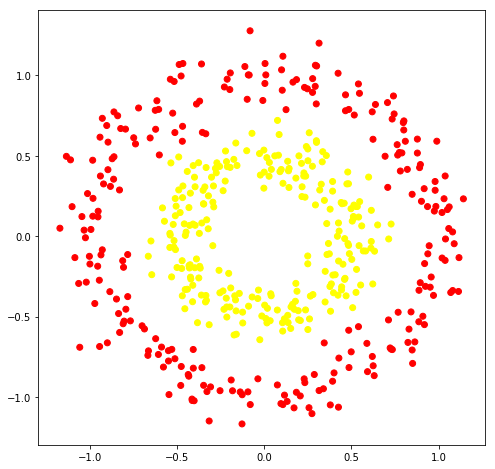

0:00:00.475685


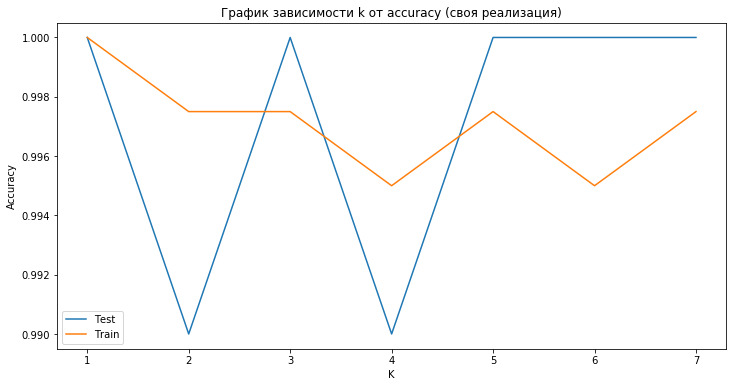

In [7]:
X, y = make_circles(n_samples=500, noise=0.09, factor=0.5, random_state=42)
plot_2d(X,y)
classifier_result(X,y)

#### 1.3 Тестирование на датасете make_moons

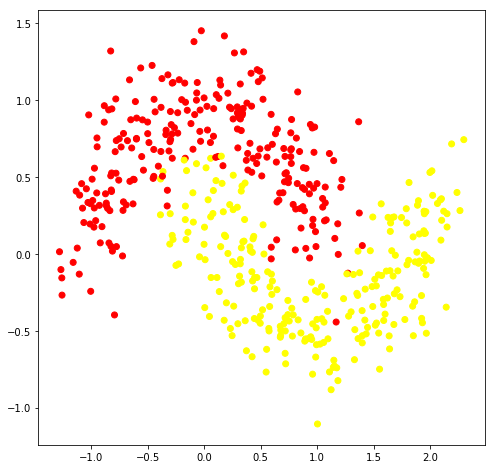

0:00:00.649316


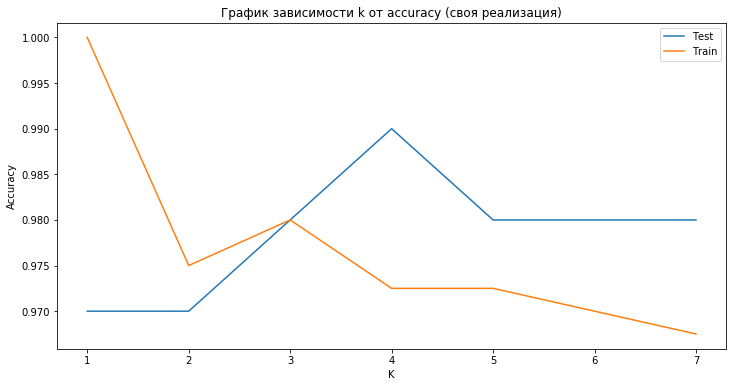

In [272]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=0)
plot_2d(X,y)
classifier_result(X,y)

### 2. Metrics

In [319]:
C="Cat"
F="Fish"
H="Hen"

# истинные значения
y_true = [C,C,C,C,C,C, F,F,F,F,F,F,F,F,F,F, H,H,H,H,H,H,H,H,H,C,C,C,C,C,C,C, F,F,F,F,F,F,F,F,F,F, H,H,H,H,H,H,H,H,H]
# результат системы
y_pred = [C,C,C,C,H,F, C,C,C,C,C,C,H,H,F,F, C,C,C,H,H,H,H,H,H,C,C, F,F,F,F,F,F,F,F,F,F, H,H,H,C,C, F,F,F,F,F,F,F,F,H]

In [320]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         Cat       0.35      0.46      0.40        13
        Fish       0.33      0.35      0.34        20
         Hen       0.54      0.39      0.45        18

   micro avg       0.39      0.39      0.39        51
   macro avg       0.41      0.40      0.40        51
weighted avg       0.41      0.39      0.40        51



Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

In [321]:
from sklearn.metrics import confusion_matrix, classification_report
start_time = datetime.now()
confusion_matrix(y_true, y_pred)
print(datetime.now() - start_time)

start_time = datetime.now()
conf_matr(y_true, y_pred)
print(datetime.now() - start_time)

0:00:00.000996
0:00:00.006491


In [322]:
def conf_matr(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    un_var = np.unique(y_true)
    k = len(un_var)
    matrix = pd.DataFrame(columns=un_var, index=np.arange(k))
    for i in range(k):
        classes, var = np.unique(y_pred[y_true == un_var[i]], return_counts=True)
        matrix.iloc[i][classes] = var       
    return np.array(matrix.fillna(0))

def rep_classification(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    conf_matrix = conf_matr(y_true, y_pred)
    k = conf_matrix.shape[0]
    matrix = np.zeros((k+3, 4))
    un_var = np.unique(y_true, return_counts=True)[1]
    
    for i in range(k):
        matrix[i,0] = np.round(conf_matrix[i,i]/np.sum(conf_matrix[:,i]),3)
        matrix[i,1] = np.round(conf_matrix[i,i]/np.sum(conf_matrix[i,:]),3)
        matrix[i,2] = np.round(2*matrix[i,0]*matrix[i,1]/(matrix[i,0] + matrix[i,1]),3)
        matrix[i,3] = np.round(un_var[i],3)
    matrix[k, :-1] = np.round(np.mean(y_true==y_pred),3)
    matrix[k+1,:-1] = np.round(np.mean(matrix[:k,:-1], axis=0),3)
    matrix[k+2,:-1] = np.round(np.dot(matrix[:k,-1], matrix[:k,:-1])/len(y_true),3)
    matrix[k:,-1] = len(y_true)
    
    df = pd.DataFrame(index=np.unique(y_true).tolist() + ['micro avg','macro avg','weighted avg'],
            columns=['precision', 'recall', 'f1-score', 'support'])
    df.loc[:] = matrix
    return df
        
    
rep_classification(y_true, y_pred)

,precision,recall,f1-score,support
Cat,0.353,0.462,0.400,13.0
Fish,0.333,0.350,0.341,20.0
Hen,0.538,0.389,0.452,18.0
micro avg,0.392,0.392,0.392,51.0
macro avg,0.408,0.400,0.398,51.0
weighted avg,0.410,0.392,0.395,51.0


### 3. Linreg

In [369]:
from sklearn.datasets import load_diabetes
data = load_diabetes()

X = data['data']
y = data['target']

df = pd.DataFrame(np.c_[X, y])
df.columns = data['feature_names'] + ['target']

###### Названия регрессеров:
- age age in years

- sex

- bmi body mass index

- bp average blood pressure

- s1 tc, T-Cells (a type of white blood cells)

- s2 ldl, low-density lipoproteins

- s3 hdl, high-density lipoproteins

- s4 tch, thyroid stimulating hormone

- s5 ltg, lamotrigine

- s6 glu, blood sugar level

In [371]:
# Проверили корреляцию с зависимой переменной
# Видим плохую корреляцию с sex, что логично, так как это дамми-переменная
df[df.columns[:-1]].corrwith(df[df.columns[-1]])

age    0.187889
sex    0.043062
bmi    0.586450
bp     0.441484
s1     0.212022
s2     0.174054
s3    -0.394789
s4     0.430453
s5     0.565883
s6     0.382483
dtype: float64

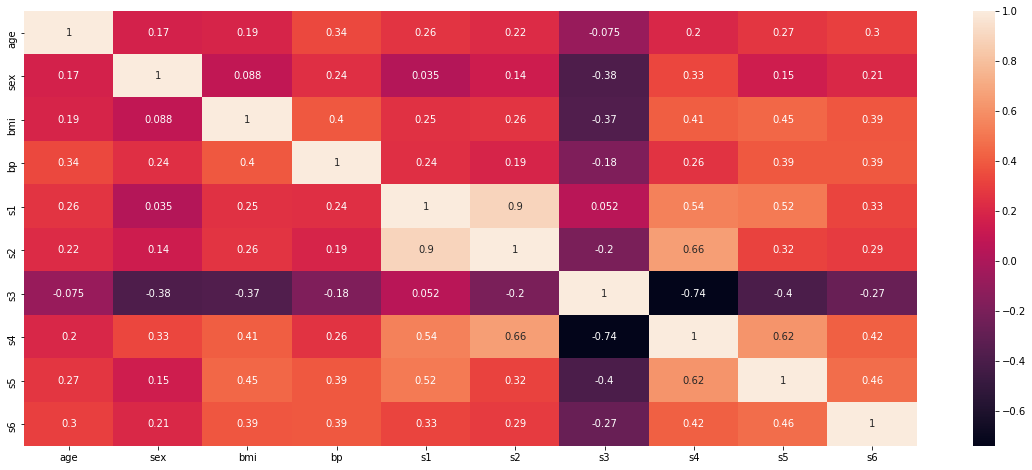

In [477]:
# Сильной корреляции между независимыми переменными не наблюдается, кроме s3 и s4, но это допустимо
plt.figure(figsize=(20,8))
sns.heatmap(df.iloc[:,:-1].corr(), annot=True, square=False)

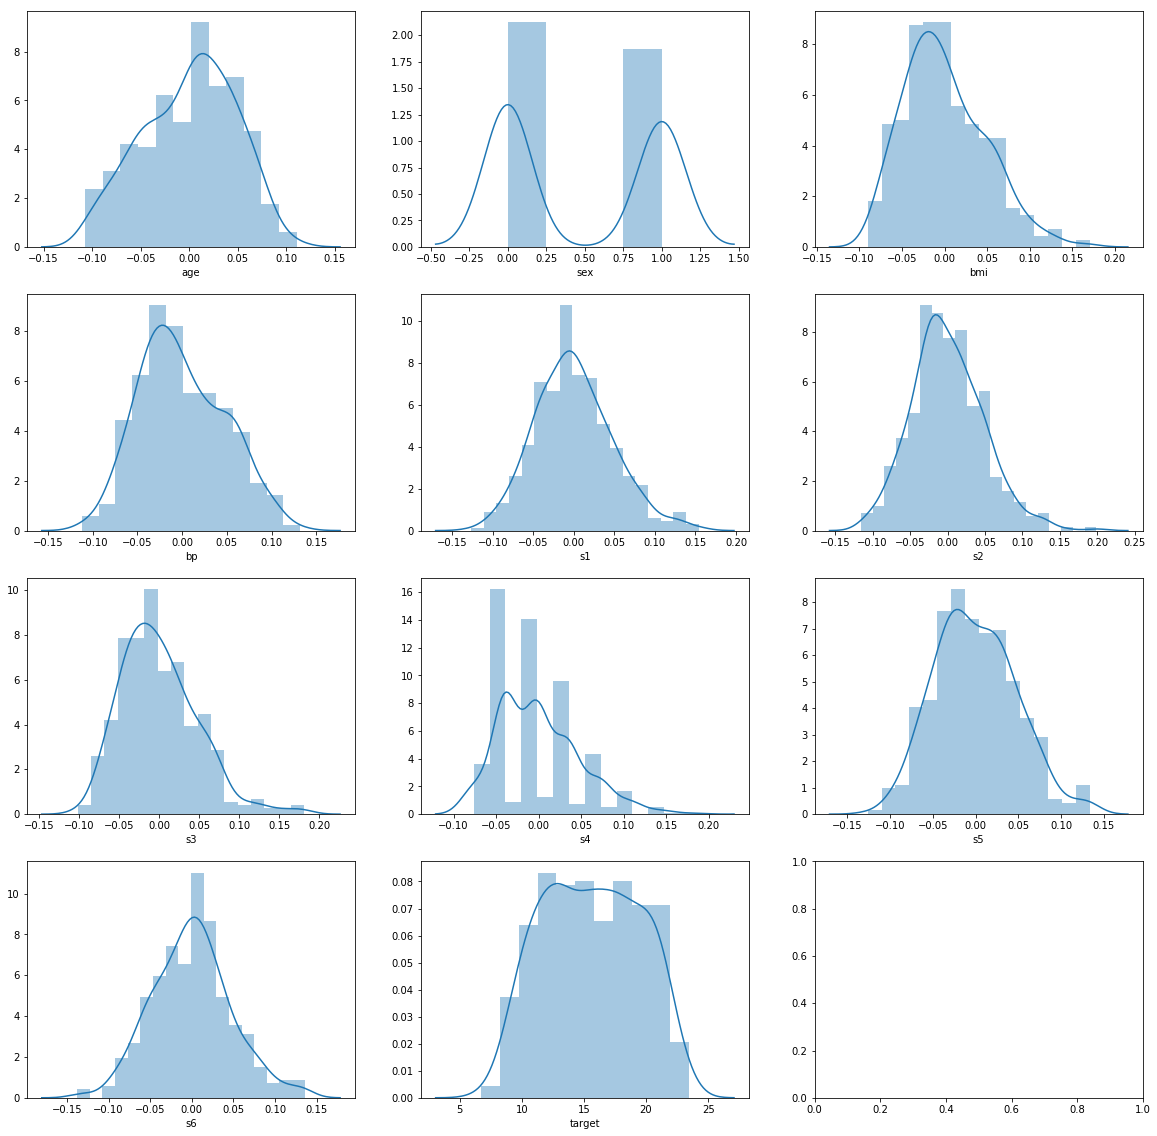

In [538]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
for idx,feat in enumerate(df.columns):
    sns.distplot(df[feat], ax=axes[idx // 3, idx % 3])

In [562]:
# Тк данные отнормированы, переменную "пол" переделал в дамми 
# Удалил s4
df['sex'] = df['sex'].apply(lambda x: 0 if x <= 0 else 1)
df['sex']=df['sex'].astype(int)
df['sex'].value_counts()
# df.drop('s4', inplace=True, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
age       442 non-null float64
sex       442 non-null int32
bmi       442 non-null float64
bp        442 non-null float64
s1        442 non-null float64
s2        442 non-null float64
s3        442 non-null float64
s5        442 non-null float64
s6        442 non-null float64
target    442 non-null float64
dtypes: float64(9), int32(1)
memory usage: 32.9 KB


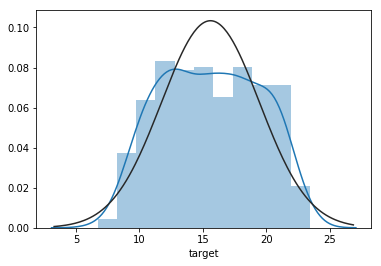

In [525]:
# Постарался хоть как-то привести зависимую перменную к нормальному распределению
from scipy.special import boxcox1p
from scipy.stats import norm

target = boxcox1p(df['target'], 0.4)
sns.distplot(target, fit=norm)
df['target'] = target

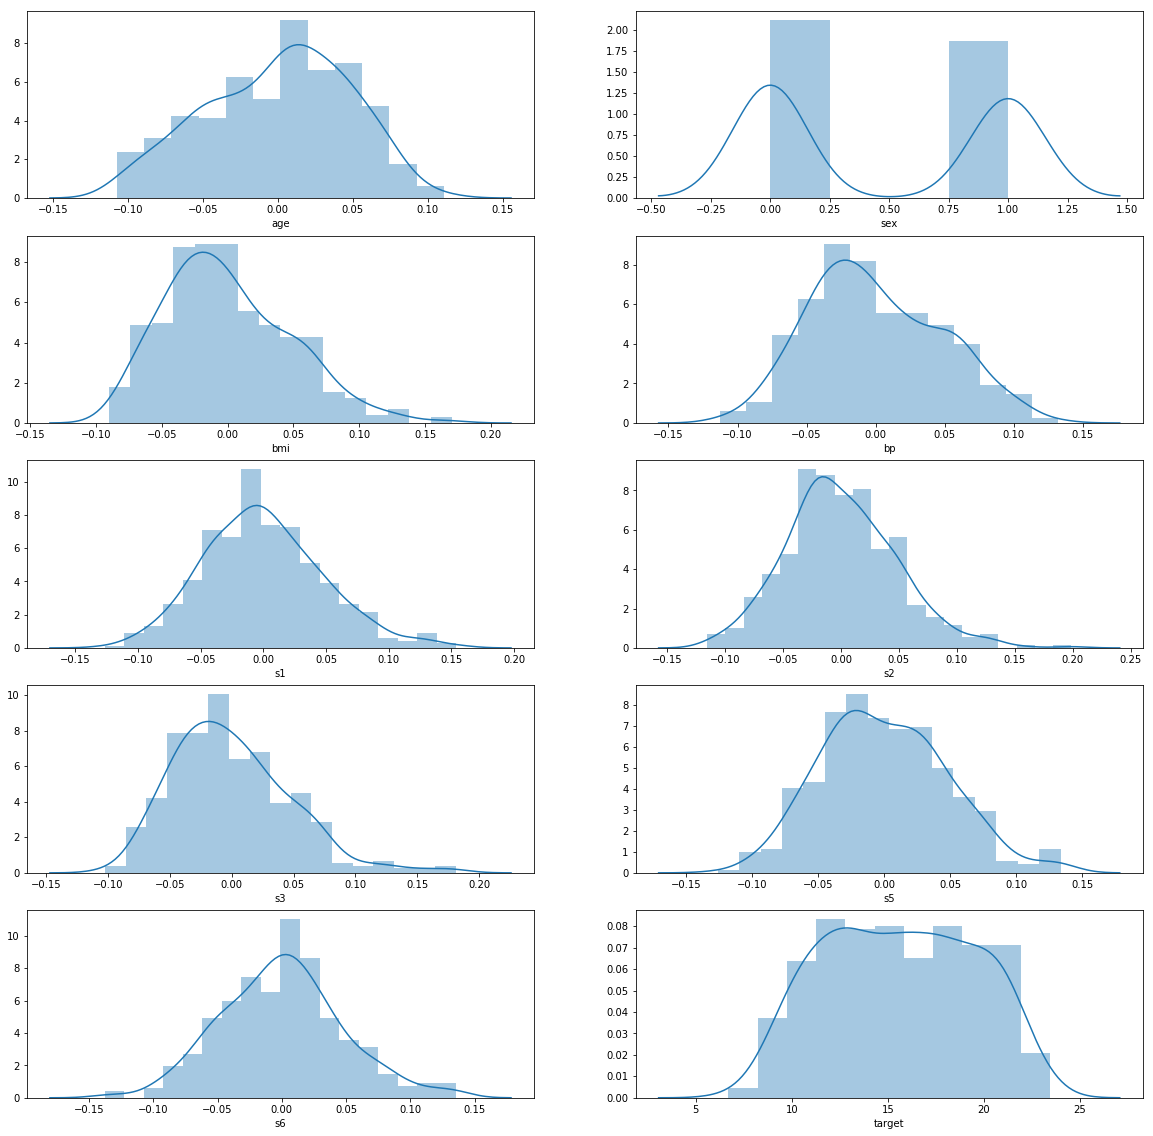

In [552]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
for idx,feat in enumerate(df.columns):
    sns.distplot(df[feat], ax=axes[idx // 2, idx % 2])

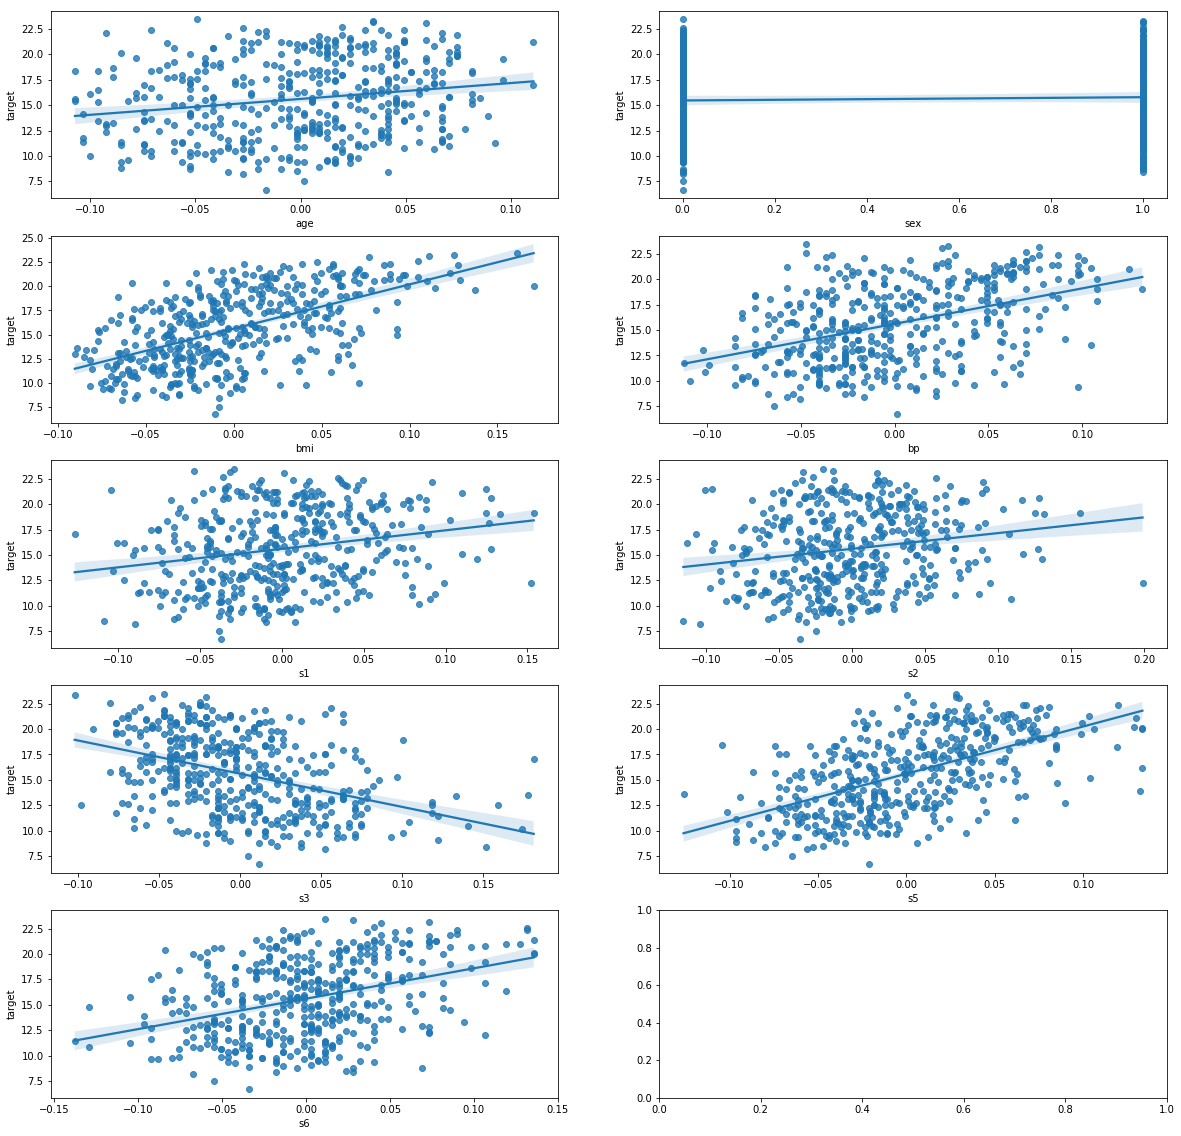

In [564]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

for idx,feat in enumerate(df.columns[:-1]):
    sns.regplot(y='target', x=feat, data=df, ax=axes[idx // 2, idx % 2])

In [589]:
df['sex']=df['sex'].astype(object)
df = pd.get_dummies(df, drop_first=True)
columns = df.columns.tolist()
df = df[columns[:-2] + columns[-1:] + columns[-2:-1]]

In [590]:
df.head()

,age,bmi,bp,s1,s2,s3,s5,s6,sex_1,target
0,0.038076,0.061696,0.021872,-0.044223,-0.034821,-0.043401,0.019908,-0.017646,1,16.149940
1,-0.001882,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.068330,-0.092204,0,11.634012
2,0.085299,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,0.002864,-0.025930,1,15.649111
3,-0.089063,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.022692,-0.009362,0,18.602220
4,0.005383,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.031991,-0.046641,0,15.338387


###### Модели линейной регрессии

In [591]:
def get_R_square(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train,y_train)
    return [model.score(X_test, y_test), mse(y_test, model.predict(X_test))]

R_squares = []
for columns in df.columns[:-1]:
    X_train, X_test, y_train, y_test = train_test_split(df[columns].values.reshape((-1,1)), df['target'].values.reshape((-1,1)), train_size=0.7, random_state=42)
    R_squares.append(get_R_square(X_train, X_test, y_train, y_test))
R_squares = np.asarray(R_squares)

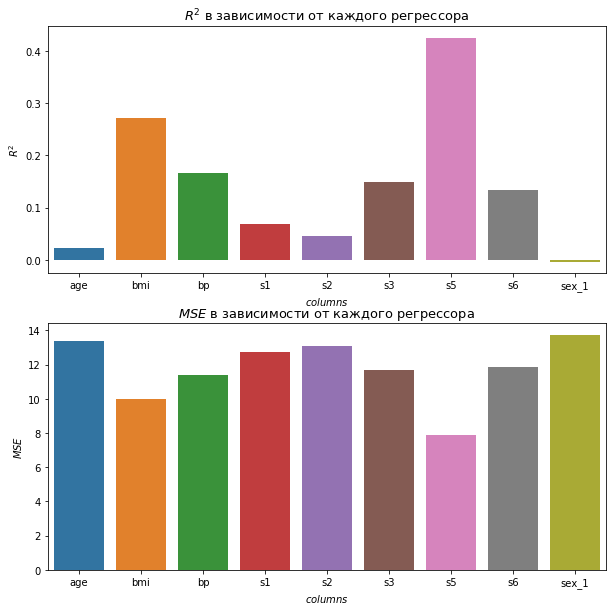

In [592]:
# Лучший R^2 дает переменная s5
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
ax1 = sns.barplot(df.columns[:-1], R_squares[:,0], ax=axes[0])
ax2 = sns.barplot(df.columns[:-1], R_squares[:,1], ax=axes[1])

ax1.axes.set_title("$R^2$ в зависимости от каждого регрессора",fontsize=13)
ax1.set_xlabel('$columns$',fontsize=10)
ax1.set_ylabel('$R^2$',fontsize=10)

ax2.axes.set_title("$MSE$ в зависимости от каждого регрессора",fontsize=13)
ax2.set_xlabel('$columns$',fontsize=10)
ax2.set_ylabel('$MSE$',fontsize=10)
plt.show()

In [593]:
R_squares = []
cols = []
for columns in df.columns[:-1]:
    cols.append(columns)
    X_train, X_test, y_train, y_test = train_test_split(df[cols].values, df['target'].values.reshape((-1,1)), train_size=0.7, random_state=42)
    R_squares.append(get_R_square(X_train, X_test, y_train, y_test))
R_squares = np.asarray(R_squares)

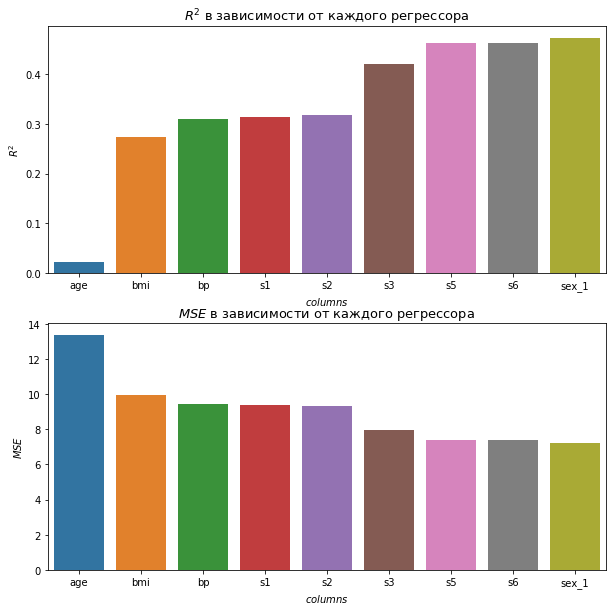

In [594]:
# С ростом сложности модели ошибка падает и R^2 увеличивается
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
ax1 = sns.barplot(df.columns[:-1], R_squares[:,0], ax=axes[0])
ax2 = sns.barplot(df.columns[:-1], R_squares[:,1], ax=axes[1])

ax1.axes.set_title("$R^2$ в зависимости от каждого регрессора",fontsize=13)
ax1.set_xlabel('$columns$',fontsize=10)
ax1.set_ylabel('$R^2$',fontsize=10)

ax2.axes.set_title("$MSE$ в зависимости от каждого регрессора",fontsize=13)
ax2.set_xlabel('$columns$',fontsize=10)
ax2.set_ylabel('$MSE$',fontsize=10)
plt.show()